In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is alr

In [10]:
from google.colab import files
uploaded = files.upload()

Saving realme narzo60 reviews.csv to realme narzo60 reviews (1).csv


In [11]:
reviews=pd.read_csv("realme narzo60 reviews.csv",encoding='Latin-1')
reviews

,ID,Profile Name,Review,Review date,rating,Colour,Size
0,RINNVKXRE6O3G,Sheikh Saheb,"I recently purchased the Realme Narzo 60, and ...",24 July 2023,4,Cosmic Black,8 GB Ram + 128 GB Storage
1,R3QWPVEBADK868,ayush,Cons1.The camera could be improved ( it's dece...,20 July 2023,4,Mars Orange,8 GB Ram + 256 GB Storage
2,R5WDIFT5US2JL,Darpan,2 days reviewGood budget mobileProne display i...,25 July 2023,4,Mars Orange,8 GB Ram + 128 GB Storage
3,R9BT70DI20PVI,Vaibhav Tiwari,"Good DisplayGood battery, more than 8 hours of...",26 July 2023,4,Mars Orange,8 GB Ram + 128 GB Storage
4,R2PGKV2O15DPG2,Mukesh Kumar Gupta,Display -very goodCamera -good accepted more ...,24 July 2023,4,Mars Orange,8 GB Ram + 256 GB Storage
...,...,...,...,...,...,...,...
91,R1NXZRX6H2FLI2,subhransu nayak,Fast charging with great battery backup.Better...,20 July 2023,5,Cosmic Black,8 GB Ram + 128 GB Storage
92,R30TVBMGMN46SJ,Ramesh Reddy,"Very nice mobile, performance and 6.4 inch siz...",21 July 2023,5,Mars Orange,8 GB Ram + 128 GB Storage
93,R3O30SCX6CZCFF,Safar,Best phone under this budget.smooth and fine g...,22 July 2023,5,Cosmic Black,8 GB Ram + 128 GB Storage
94,RRD6JQOUQONAO,Rishabh,Impressive camera quality captures stunning ph...,22 July 2023,5,Cosmic Black,8 GB Ram + 128 GB Storage


In [12]:
reviews.rating.describe()

count    96.000000
mean      4.333333
std       0.790292
min       3.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: rating, dtype: float64

In [13]:
# Number of Words
reviews['word_count'] = reviews['Review'].apply(lambda x: len(str(x).split(" ")))
reviews[['Review','word_count']].head()

,Review,word_count
0,"I recently purchased the Realme Narzo 60, and ...",257
1,Cons1.The camera could be improved ( it's dece...,192
2,2 days reviewGood budget mobileProne display i...,34
3,"Good DisplayGood battery, more than 8 hours of...",27
4,Display -very goodCamera -good accepted more ...,35


In [14]:
# Number of Characters
reviews['char_count'] = reviews['Review'].str.len() ## this also includes spaces
reviews[['Review','char_count']].head()

,Review,char_count
0,"I recently purchased the Realme Narzo 60, and ...",1648
1,Cons1.The camera could be improved ( it's dece...,1136
2,2 days reviewGood budget mobileProne display i...,260
3,"Good DisplayGood battery, more than 8 hours of...",155
4,Display -very goodCamera -good accepted more ...,247


In [15]:
# Average Word Length
def avg_word(sentence):
  words = str(sentence).split()
  return (sum(len(word) for word in words)/len(words))

reviews['avg_word'] = reviews['Review'].apply(lambda x: avg_word(x))
reviews[['Review','avg_word']].head()

,Review,avg_word
0,"I recently purchased the Realme Narzo 60, and ...",5.416342
1,Cons1.The camera could be improved ( it's dece...,4.921875
2,2 days reviewGood budget mobileProne display i...,6.676471
3,"Good DisplayGood battery, more than 8 hours of...",4.961538
4,Display -very goodCamera -good accepted more ...,6.264706


In [16]:
# Number of Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

reviews['stopwords'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
reviews[['Review','stopwords']].head()

,Review,stopwords
0,"I recently purchased the Realme Narzo 60, and ...",95
1,Cons1.The camera could be improved ( it's dece...,69
2,2 days reviewGood budget mobileProne display i...,9
3,"Good DisplayGood battery, more than 8 hours of...",5
4,Display -very goodCamera -good accepted more ...,4


In [17]:
# Number of Special Characters
reviews['hashtags'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
reviews[['Review','hashtags']].head()

,Review,hashtags
0,"I recently purchased the Realme Narzo 60, and ...",0
1,Cons1.The camera could be improved ( it's dece...,0
2,2 days reviewGood budget mobileProne display i...,0
3,"Good DisplayGood battery, more than 8 hours of...",0
4,Display -very goodCamera -good accepted more ...,0


In [18]:
# Number of Numerics
reviews['numerics'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
reviews[['Review','numerics']].head()

,Review,numerics
0,"I recently purchased the Realme Narzo 60, and ...",3
1,Cons1.The camera could be improved ( it's dece...,1
2,2 days reviewGood budget mobileProne display i...,2
3,"Good DisplayGood battery, more than 8 hours of...",2
4,Display -very goodCamera -good accepted more ...,0


In [19]:
# Number of Uppercase Words
reviews['upper'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
reviews[['Review','upper']].head()

,Review,upper
0,"I recently purchased the Realme Narzo 60, and ...",6
1,Cons1.The camera could be improved ( it's dece...,2
2,2 days reviewGood budget mobileProne display i...,0
3,"Good DisplayGood battery, more than 8 hours of...",0
4,Display -very goodCamera -good accepted more ...,0


In [20]:
reviews.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','upper'],axis=1,inplace=True)

**Spelling Corrections**

-->We’ve all seen tweets with a plethora of spelling mistakes. Our timelines are often filled with hastly sent tweets that are barely legible at times.

-->In that regard, spelling correction is a useful pre-processing step because this also will help us in reducing multiple copies of words.

-->To achieve this we will use the textblob library. If you are not familiar with it, you can check my previous article on ‘NLP for beginners using textblob.

In [21]:
# Spelling Corrections
from textblob import TextBlob
reviews['Review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    I recently purchased the Realm Cargo 60, and I...
1    Sons.The camera could be improved ( it's decen...
2    2 days reviewGood budget mobileProne display i...
3    Good DisplayGood battery, more than 8 hours of...
4    Display -very goodCamera -good  accepted more ...
Name: Review, dtype: object

**Feature Engineering**

In [22]:
print(reviews['Review date'].str.split(' ').str[0], '\n',
      reviews['Review date'].str.split(' ').str[1], '\n',
      reviews['Review date'].str.split(' ').str[2])

0     24
1     20
2     25
3     26
4     24
      ..
91    20
92    21
93    22
94    22
95    22
Name: Review date, Length: 96, dtype: object 
 0     July
1     July
2     July
3     July
4     July
      ... 
91    July
92    July
93    July
94    July
95    July
Name: Review date, Length: 96, dtype: object 
 0     2023
1     2023
2     2023
3     2023
4     2023
      ... 
91    2023
92    2023
93    2023
94    2023
95    2023
Name: Review date, Length: 96, dtype: object


In [23]:
#Spliting Review Date into Three seperate Columns (Year,Month,Day)
df=reviews.copy()
df['Date']=df['Review date'].str.split(' ').str[0]
df['Month']=df['Review date'].str.split(' ').str[1]
df['Year']=df['Review date'].str.split(' ').str[2]
df[['Date','Month','Year']]

,Date,Month,Year
0,24,July,2023
1,20,July,2023
2,25,July,2023
3,26,July,2023
4,24,July,2023
...,...,...,...
91,20,July,2023
92,21,July,2023
93,22,July,2023
94,22,July,2023


In [24]:
df.Month.value_counts()

July    96
Name: Month, dtype: int64

In [25]:
# Change 'month' from words to numbers for easier analysis
order={"Month":{'July': 7}}
df1= df.copy()
df1=df1.replace(order)
df1[['Month']]

,Month
0,7
1,7
2,7
3,7
4,7
...,...
91,7
92,7
93,7
94,7


In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              96 non-null     object
 1   Profile  Name   96 non-null     object
 2   Review          96 non-null     object
 3   Review date     96 non-null     object
 4   rating          96 non-null     int64 
 5   Colour          96 non-null     object
 6   Size            96 non-null     object
 7   Date            96 non-null     object
 8   Month           96 non-null     int64 
 9   Year            96 non-null     object
dtypes: int64(2), object(8)
memory usage: 7.6+ KB


In [27]:
df1[['Date','Year']]=df1[['Date','Year']].astype('int64')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              96 non-null     object
 1   Profile  Name   96 non-null     object
 2   Review          96 non-null     object
 3   Review date     96 non-null     object
 4   rating          96 non-null     int64 
 5   Colour          96 non-null     object
 6   Size            96 non-null     object
 7   Date            96 non-null     int64 
 8   Month           96 non-null     int64 
 9   Year            96 non-null     int64 
dtypes: int64(4), object(6)
memory usage: 7.6+ KB


In [28]:
# Dropping the Original Columns after splitting the data
df1.drop('Review date',axis=1, inplace=True)
df1.head()

,ID,Profile Name,Review,rating,Colour,Size,Date,Month,Year
0,RINNVKXRE6O3G,Sheikh Saheb,"I recently purchased the Realme Narzo 60, and ...",4,Cosmic Black,8 GB Ram + 128 GB Storage,24,7,2023
1,R3QWPVEBADK868,ayush,Cons1.The camera could be improved ( it's dece...,4,Mars Orange,8 GB Ram + 256 GB Storage,20,7,2023
2,R5WDIFT5US2JL,Darpan,2 days reviewGood budget mobileProne display i...,4,Mars Orange,8 GB Ram + 128 GB Storage,25,7,2023
3,R9BT70DI20PVI,Vaibhav Tiwari,"Good DisplayGood battery, more than 8 hours of...",4,Mars Orange,8 GB Ram + 128 GB Storage,26,7,2023
4,R2PGKV2O15DPG2,Mukesh Kumar Gupta,Display -very goodCamera -good accepted more ...,4,Mars Orange,8 GB Ram + 256 GB Storage,24,7,2023


In [29]:
df

,ID,Profile Name,Review,Review date,rating,Colour,Size,Date,Month,Year
0,RINNVKXRE6O3G,Sheikh Saheb,"I recently purchased the Realme Narzo 60, and ...",24 July 2023,4,Cosmic Black,8 GB Ram + 128 GB Storage,24,July,2023
1,R3QWPVEBADK868,ayush,Cons1.The camera could be improved ( it's dece...,20 July 2023,4,Mars Orange,8 GB Ram + 256 GB Storage,20,July,2023
2,R5WDIFT5US2JL,Darpan,2 days reviewGood budget mobileProne display i...,25 July 2023,4,Mars Orange,8 GB Ram + 128 GB Storage,25,July,2023
3,R9BT70DI20PVI,Vaibhav Tiwari,"Good DisplayGood battery, more than 8 hours of...",26 July 2023,4,Mars Orange,8 GB Ram + 128 GB Storage,26,July,2023
4,R2PGKV2O15DPG2,Mukesh Kumar Gupta,Display -very goodCamera -good accepted more ...,24 July 2023,4,Mars Orange,8 GB Ram + 256 GB Storage,24,July,2023
...,...,...,...,...,...,...,...,...,...,...
91,R1NXZRX6H2FLI2,subhransu nayak,Fast charging with great battery backup.Better...,20 July 2023,5,Cosmic Black,8 GB Ram + 128 GB Storage,20,July,2023
92,R30TVBMGMN46SJ,Ramesh Reddy,"Very nice mobile, performance and 6.4 inch siz...",21 July 2023,5,Mars Orange,8 GB Ram + 128 GB Storage,21,July,2023
93,R3O30SCX6CZCFF,Safar,Best phone under this budget.smooth and fine g...,22 July 2023,5,Cosmic Black,8 GB Ram + 128 GB Storage,22,July,2023
94,RRD6JQOUQONAO,Rishabh,Impressive camera quality captures stunning ph...,22 July 2023,5,Cosmic Black,8 GB Ram + 128 GB Storage,22,July,2023


**Data Visualization**

Date Versus Review Count

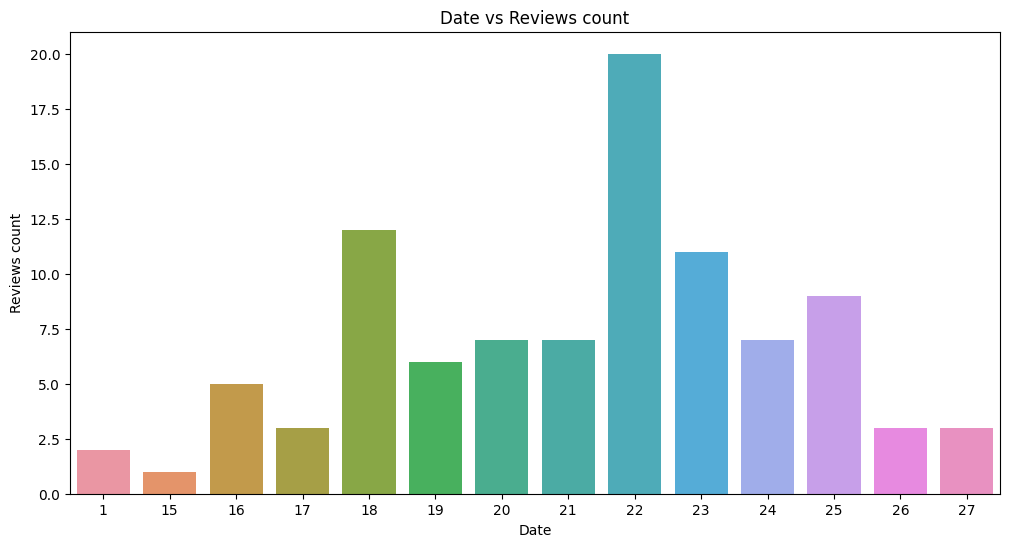

In [30]:
#Creating a DataFrame
dayreview = pd.DataFrame(df.groupby('Date')['Review'].count()).reset_index()
dayreview['Date'] = dayreview['Date'].astype('int64')
dayreview.sort_values(by = ['Date'])

#Plotting the grah
plt.figure(figsize=(12,6))
sns.barplot(x= "Date", y = "Review", data = dayreview)
plt.title('Date vs Reviews count')
plt.xlabel('Date')
plt.ylabel('Reviews count')
plt.show()


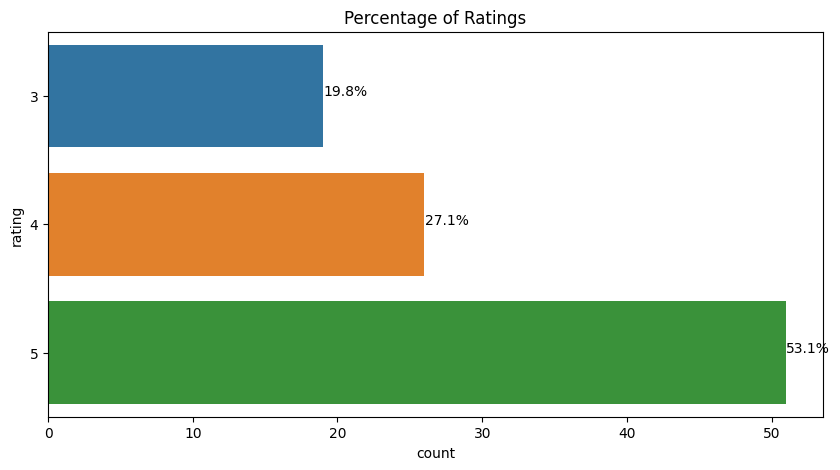

In [31]:
plt.figure(figsize=(10,5))
plt.title('Percentage of Ratings')
ax = sns.countplot(y = 'rating', data = reviews)
total = len(reviews)
for p in ax.patches:
      percentage = '{:.1f}%'.format(100 * p.get_width()/total)
      x = p.get_x() + p.get_width() + 0.02
      y = p.get_y() + p.get_height()/2
      ax.annotate(percentage, (x,y))

Basic Text Preprocressing

Sentiment Analysis

In [32]:
data = df[['Review']]
data

,Review
0,"I recently purchased the Realme Narzo 60, and ..."
1,Cons1.The camera could be improved ( it's dece...
2,2 days reviewGood budget mobileProne display i...
3,"Good DisplayGood battery, more than 8 hours of..."
4,Display -very goodCamera -good accepted more ...
...,...
91,Fast charging with great battery backup.Better...
92,"Very nice mobile, performance and 6.4 inch siz..."
93,Best phone under this budget.smooth and fine g...
94,Impressive camera quality captures stunning ph...


In [33]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data['Review'] = data['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \
                                    if x not in stop_words))

In [34]:
data

,Review
0,"i recently purchased realme narzo 60, i must s..."
1,cons1.the camera could improved ( decent) i dr...
2,2 days reviewgood budget mobileprone display g...
3,"good displaygood battery, 8 hours backupgood c..."
4,display -very goodcamera -good accepted better...
...,...
91,fast charging great battery backup.better ui c...
92,"very nice mobile, performance 6.4 inch size at..."
93,best phone budget.smooth fine gameplay.
94,impressive camera quality captures stunning ph...


In [35]:
lemmatizer = WordNetLemmatizer()

# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(data))):
    cleaned= re.sub('[^a-zA-Z]', " ", data["Review"][i])
    cleaned= cleaned.lower()
    cleaned = cleaned.split()
    cleaned= [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned= ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/96 [00:00<?, ?it/s]

In [36]:
#Saving cleaned data to compare with original data, to ckeck amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": df.Review})
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...


Text Pre-Processing Techniques

Pre-Processing 'KEY WORDS'

In [37]:
#  Removing '@names'
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)

    return text

In [38]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
dataframe['Clean_Reviews'] = np.vectorize(remove_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [39]:
# Removing links (http | https)
cleaned_reviews = []

for index, row in dataframe.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [40]:
# Dropping duplicate rows
dataframe.drop_duplicates(subset=['Clean_Reviews'], keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [41]:
# Resettings Index
dataframe = dataframe.reset_index(drop=True)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [42]:
# Removing Punctuations, Numbers and Special characters
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [43]:
dataframe['Clean_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: clean_text(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [44]:
# Removing links (http | https)
cleaned_reviews = []

for index, row in dataframe.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [45]:
# Removing Review with empty Text
dataframe = dataframe[dataframe['Clean_Reviews']!='']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [46]:
#REmoving Review with empty text
dataFrame = dataframe[dataframe['Clean_Reviews']!='']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [47]:
# Dropping duplicate rows
dataframe.drop_duplicates(subset=['Clean_Reviews'], keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [48]:
# Resetting index
dataframe = dataframe.reset_index(drop=True)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [49]:
# Removing Punctuations, Numbers and Special characters
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [52]:
dataframe['Clean_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: clean_text(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤
8,quality photo,The quality of the photo
9,black color back leather,Black color back not leather


In [55]:
# Function to remove emoji
def remove_emoji(text):
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emotions
                          u"\U0001F600-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (ios)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

In [60]:
dataframe['Clean_Reviews']=dataframe['Clean_Reviews'].apply(lambda x: remove_emoji(x))
dataframe.head(10)

error: ignored

In [59]:
dataframe['tokenized_tweets'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews,tokenized_tweets
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ...","[recently, purchased, realme, narzo, must, say..."
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...,"[con, camera, could, improved, decent, dropped..."
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...,"[day, reviewgood, budget, mobileprone, display..."
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of...","[good, displaygood, battery, hour, backupgood,..."
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...,"[display, goodcamera, good, accepted, better, ..."
5,phone amazingthose doubt regarding leather ple...,This phone is amazingThose of you who have dou...,"[phone, amazingthose, doubt, regarding, leathe..."
6,camera sound could better overall performance ...,Camera and sound could be better. Overall perf...,"[camera, sound, could, better, overall, perfor..."
7,thikthak,Thikthak à¤à¤¾à¤®à¤à¤²à¤¾à¤,[thikthak]
8,quality photo,The quality of the photo,"[quality, photo]"
9,black color back leather,Black color back not leather,"[black, color, back, leather]"


In [61]:
dataframe.drop(['tokenized_tweets'],axis=1,inplace=True)

In [62]:
import pandas as pd
import io

In [63]:
from google.colab import files
uploaded = files.upload()

Saving stop.txt to stop.txt


In [64]:
# Removing Stop words
stop = pd.read_csv(io.StringIO(uploaded["stop.txt"].decode("ISO-8859-1")))
print(stop)

              a
0           a's
1          able
2         about
3         above
4     according
..          ...
565       yours
566    yourself
567  yourselves
568           z
569        zero

[570 rows x 1 columns]


In [65]:
print(stop[:101])

                a
0             a's
1            able
2           about
3           above
4       according
..            ...
96   consequently
97       consider
98    considering
99        contain
100    containing

[101 rows x 1 columns]


In [68]:
TextBlob(dataframe['Clean_Reviews'][1]).words

WordList(['con', 'camera', 'could', 'improved', 'decent', 'dropped', 'pic', 'bloatware', 'removed', 'widht', 'screen', 'could', 'little', 'processor', 'might', 'low', 'gamers', 'still', 'work', 'smoothly', 'best', 'non', 'e', 'sport', 'player', 'pro', 'honestly', 'cool', 'impressive', 'design', 'go', 'orange', 'colour', 'good', 'design', 'pov', 'far', 'better', 'iphone', 'smooth', 'use', 'good', 'feature', 'battery', 'life', 'good', 'even', 'heavy', 'user', 'battery', 'life', 'use', 'low', 'performance', 'mode', 'even', 'low', 'performance', 'mode', 'phone', 'work', 'smoothly', 'people', 'complaining', 'max', 'screen', 'brightness', 'alright', 'lag', 'even', 'opening', 'apps', 'fingerprint', 'face', 'lock', 'work', 'smoothly', 'quickly', 'inbuilt', 'app', 'lock', 'goodcomparable', 'iphone', 'speed', 'unlocking', 'face', 'one', 'speaker', 'given', 'good', 'problem', 'always', 'display', 'phone', 'consumes', 'le', 'battery', 'customisable', 'good', 'design', 'also', 'customise', 'many', 

In [69]:
tokenized_review = dataframe['Clean_Reviews'].apply(lambda x: x.split())
tokenized_review.head(10)

0    [recently, purchased, realme, narzo, must, say...
1    [con, camera, could, improved, decent, dropped...
2    [day, reviewgood, budget, mobileprone, display...
3    [good, displaygood, battery, hour, backupgood,...
4    [display, goodcamera, good, accepted, better, ...
5    [phone, amazingthose, doubt, regarding, leathe...
6    [camera, sound, could, better, overall, perfor...
7                                           [thikthak]
8                                     [quality, photo]
9                        [black, color, back, leather]
Name: Clean_Reviews, dtype: object

In [70]:
from nltk.stem.snowball import SnowballStemmer

# Use English Stemmer.
stemmer = SnowballStemmer("english")

In [71]:
xx = pd.DataFrame()
xx['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
xx

,stemmed
0,recent purchas realm narzo must say outstand b...
1,con camera could improv decent drop pic bloatw...
2,day reviewgood budget mobilepron display good ...
3,good displaygood batteri hour backupgood camer...
4,display goodcamera good accept better qualiti ...
...,...
91,fast charg great batteri backup better ui came...
92,nice mobil perform inch size attract camera qu...
93,best phone budget smooth fine gameplay
94,impress camera qualiti captur stun photo video


In [72]:
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')
yy=pd.DataFrame()
yy['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
yy

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,stemmed
0,recently purchased realme narzo must say outst...
1,con camera could improved decent dropped pic b...
2,day reviewgood budget mobileprone display good...
3,good displaygood battery hour backupgood camer...
4,display goodcamera good accepted better qualit...
...,...
91,fast charging great battery backup better ui c...
92,nice mobile performance inch size attractive c...
93,best phone budget smooth fine gameplay
94,impressive camera quality capture stunning pho...


**Basic Feature Extraction**

Applying Bag of Words without N grams

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)

In [74]:
# Print(cv.vocabulary_)
print(cv.get_feature_names_out()[109:200])

['charging' 'charming' 'cheaper' 'chipset' 'choice' 'choose' 'circle'
 'clarity' 'cleaner' 'clearly' 'codm' 'color' 'colour' 'come' 'coming'
 'compact' 'company' 'compared' 'comparison' 'compatibility' 'complaining'
 'con' 'concern' 'connected' 'considering' 'consit' 'constantly'
 'consumes' 'contactless' 'cool' 'coolbut' 'cosmic' 'cost' 'could' 'cover'
 'crazy' 'customisable' 'customisation' 'customise' 'cutoff' 'daily'
 'data' 'dated' 'day' 'deal' 'decent' 'decentand' 'default' 'dekha'
 'dekjo' 'delay' 'deleted' 'delight' 'delivery' 'demanding' 'descent'
 'description' 'design' 'designe' 'detailed' 'device' 'dhakke'
 'difference' 'different' 'diffrnt' 'dil' 'disabled' 'discontinue'
 'display' 'displaybattery' 'displaygood' 'disply' 'disturbed' 'doubt'
 'downgrade' 'downgraded' 'drain' 'drawback' 'dropped' 'dseign' 'due'
 'duration' 'ease' 'easily' 'easy' 'edge' 'effort' 'either' 'end'
 'enhance' 'enough']


In [76]:
print(cv.get_feature_names_out()[:100])

['aa' 'ab' 'absence' 'abt' 'accepted' 'access' 'accha' 'acche' 'acchi'
 'according' 'acha' 'achi' 'ad' 'affordable' 'agni' 'ago' 'ai' 'aisa'
 'allthe' 'almost' 'along' 'already' 'alright' 'also' 'always' 'amazing'
 'amazingcamera' 'amazingthose' 'amazon' 'amoled' 'android' 'angel'
 'another' 'anyone' 'apka' 'apna' 'app' 'appealed' 'apps' 'area' 'around'
 'aside' 'assistant' 'attractive' 'aur' 'automatic' 'average'
 'averagemobile' 'away' 'awesome' 'ayengi' 'baad' 'baap' 'back'
 'backcover' 'backup' 'backupgood' 'backupsamoled' 'bad' 'bahut' 'battary'
 'battery' 'bdhiya' 'beautiful' 'behno' 'behtar' 'believe' 'besides'
 'best' 'bestgaming' 'better' 'bettercomes' 'bhai' 'bhaiyo' 'bhi' 'bhut'
 'bit' 'black' 'bloatware' 'body' 'bohot' 'bother' 'bothering'
 'bothersome' 'bought' 'box' 'boy' 'brand' 'breeze' 'brightness'
 'brightnessfingerprint' 'brought' 'bt' 'budget' 'build' 'buy' 'call'
 'camera' 'cameragood' 'camra']


In [78]:
print(tweetscv.toarray()[100:200])

[]


In [79]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/96 [00:00<?, ?it/s]

In [80]:
corpus[3]

'good displaygood batteri hour backupgood camera camera sampl x normal photo mode singl speaker sound also good'

In [81]:
## Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [82]:
X.shape

(96, 3728)

In [84]:
cv.get_feature_names_out()[:20]

array(['aa', 'aa gaya', 'aa gaya bhai', 'ab', 'ab mai', 'ab mai aur',
       'ab mujh', 'ab mujh camera', 'absenc', 'absenc nfc',
       'absenc nfc might', 'abt', 'accept', 'accept better',
       'accept better qualiti', 'access', 'access display',
       'access display fingerprint', 'acch', 'acch camera'], dtype=object)

In [85]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [86]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names_out())
count_df

,aa,aa gaya,aa gaya bhai,ab,ab mai,ab mai aur,ab mujh,ab mujh camera,absenc,absenc nfc,...,yet test,yet test camera,yet work,yet work fine,youtub,youtub onlin,youtub onlin shop,zyada,zyada pasand,zyada pasand hai
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**TF-IDF Vectorizer**

In [87]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/96 [00:00<?, ?it/s]

In [91]:
corpus[4]

'display goodcamera good accept better qualiti price rangebatteri backup good play movi video song storag bestgam medium graphic level play codm app much disturb alreadi instal mani app'

In [92]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [93]:
X.shape

(96, 3728)

In [94]:
tfidf_v.get_feature_names_out()[:20]

array(['aa', 'aa gaya', 'aa gaya bhai', 'ab', 'ab mai', 'ab mai aur',
       'ab mujh', 'ab mujh camera', 'absenc', 'absenc nfc',
       'absenc nfc might', 'abt', 'accept', 'accept better',
       'accept better qualiti', 'access', 'access display',
       'access display fingerprint', 'acch', 'acch camera'], dtype=object)

In [95]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [96]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df

,aa,aa gaya,aa gaya bhai,ab,ab mai,ab mai aur,ab mujh,ab mujh camera,absenc,absenc nfc,...,yet test,yet test camera,yet work,yet work fine,youtub,youtub onlin,youtub onlin shop,zyada,zyada pasand,zyada pasand hai
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044935,0.044935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Named Entity Recognition(NER)**

In [97]:
reviews=[review.strip() for review in dataframe.Clean_Reviews] # remove both the leading and the trailing characters
reviews=[comment for comment in reviews if comment] # removes empty strings, because they are considered in Python as False
# Joining the list into one string/text
reviews_text=' '.join(reviews)
reviews_text[0:1000]

'recently purchased realme narzo must say outstanding budget phone tick right box camera performance battery life overall daily task performance top notch however essential mention nfc provided bloatware included pro camera camera quality realme narzo surprisingly good phone price range capture sharp vivid image excellent color reproduction making delight photography enthusiast battery life battery life impressive easily lasting full day moderate heavy usage rely extended period without constantly worrying charging performance realme narzo handle daily task ease whether multitasking running demanding apps phone performance remains smooth lag free con nfc unfortunately absence nfc might drawback user rely technology contactless like payment nfc related feature bloatware phone come pre installed bloatware bit bothersome disabled would better cleaner software experience overall looking feature packed phone fantastic camera long lasting battery excellent daily performance realme narzo perf

In [98]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=reviews_text[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [100]:
for token in doc_block[:50]:
    print(token,token.pos)

recently 86
purchased 100
realme 92
narzo 92
must 87
say 100
outstanding 84
budget 92
phone 92
tick 92
right 96
box 96
camera 92
performance 92
battery 92
life 92
overall 84
daily 84
task 92
performance 92
top 84
notch 92
however 86
essential 84
mention 92
nfc 92
provided 100
bloatware 92
included 100
pro 84
camera 92
camera 92
quality 92
realme 92
narzo 100
surprisingly 86
good 84
phone 92
price 92
range 92
capture 100
sharp 84
vivid 84
image 92
excellent 84
color 92
reproduction 92
making 100
delight 84
photography 92


In [101]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=reviews_text[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [109]:
for token in doc_block[:50]:
    print(token,token.pos_)

recently ADV
purchased VERB
realme NOUN
narzo NOUN
must AUX
say VERB
outstanding ADJ
budget NOUN
phone NOUN
tick NOUN
right PROPN
box PROPN
camera NOUN
performance NOUN
battery NOUN
life NOUN
overall ADJ
daily ADJ
task NOUN
performance NOUN
top ADJ
notch NOUN
however ADV
essential ADJ
mention NOUN
nfc NOUN
provided VERB
bloatware NOUN
included VERB
pro ADJ
camera NOUN
camera NOUN
quality NOUN
realme NOUN
narzo VERB
surprisingly ADV
good ADJ
phone NOUN
price NOUN
range NOUN
capture VERB
sharp ADJ
vivid ADJ
image NOUN
excellent ADJ
color NOUN
reproduction NOUN
making VERB
delight ADJ
photography NOUN


In [111]:
# Filtering the nouns and verbs only
one_block=reviews_text
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['feature', 'drawback', 'recommended', 'budget', 'camera', 'improved', 'dropped', 'pic', 'bloatware', 'removed', 'widht', 'screen', 'processor', 'low', 'gamers', 'work', 'player', 'design', 'go', 'colour', 'design', 'pov', 'iphone', 'use', 'feature', 'battery', 'life', 'user', 'battery', 'life', 'use', 'performance', 'mode', 'performance', 'mode', 'phone', 'work', 'people', 'complaining', 'max', 'screen', 'brightness', 'alright', 'lag', 'opening', 'apps', 'fingerprint', 'face', 'lock', 'work', 'app', 'lock', 'goodcomparable', 'iphone', 'speed', 'unlocking', 'face', 'speaker', 'given', 'problem', 'display', 'phone', 'consumes', 'battery', 'design', 'customise', 'thing', 'phone', 'use', 'likeso', 'say', 'gamers', 'user', 'go', 'camera', 'go', 'model', 'version', 'day', 'reviewgood', 'budget', 'mobileprone', 'display', 'battery', 'backup', 'greatdime', 'descent', 'updated', 'speaker', 'quality', 'uninstallconscamera', 'quality', 'improved', 'camera', 'quality', 'mobile', 'update', 'displa

In [112]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,phone,67
1,camera,50
2,battery,31
3,quality,31
4,price,18
5,design,15
6,narzo,14
7,performance,13
8,use,13
9,speaker,13


<Axes: title={'center': 'Top 10 nouns and verbs'}, xlabel='word'>

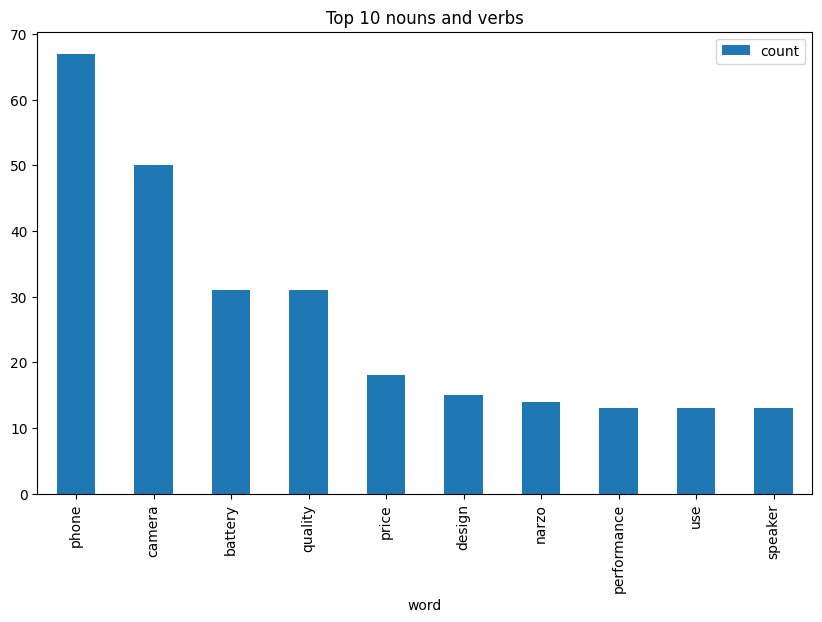

In [113]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(10,6),title='Top 10 nouns and verbs')

**Feature Extraction**

**Feature Extraction for 'Key Words'**

In [115]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

**Fetch Sentiments**

--> To proceed further, we need to know the sentiment type of every tweet, that can be done using two ways:

a. Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)

b. Using TextBlob

In [116]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

**a. Using NLTK's Sentiment lntensity Analyzer**

In [117]:
sentiments_using_SIA = dataframe.Clean_Reviews.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Clean_Reviews
pos,87
neg,9


In [118]:
dataframe.Clean_Reviews[8]

'quality photo'

In [119]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(dataframe.Clean_Reviews[8])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [120]:
df=pd.DataFrame()
df['Review'] = dataframe.Clean_Reviews
df['scores'] = dataframe['Clean_Reviews'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Review,scores
0,recently purchased realme narzo must say outst...,"{'neg': 0.14, 'neu': 0.573, 'pos': 0.286, 'com..."
1,con camera could improved decent dropped pic b...,"{'neg': 0.082, 'neu': 0.644, 'pos': 0.274, 'co..."
2,day reviewgood budget mobileprone display good...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp..."
3,good displaygood battery hour backupgood camer...,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp..."
4,display goodcamera good accepted better qualit...,"{'neg': 0.066, 'neu': 0.536, 'pos': 0.398, 'co..."


In [121]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Review,scores,compound
0,recently purchased realme narzo must say outst...,"{'neg': 0.14, 'neu': 0.573, 'pos': 0.286, 'com...",0.9820
1,con camera could improved decent dropped pic b...,"{'neg': 0.082, 'neu': 0.644, 'pos': 0.274, 'co...",0.9839
2,day reviewgood budget mobileprone display good...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.7184
3,good displaygood battery hour backupgood camer...,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",0.7003
4,display goodcamera good accepted better qualit...,"{'neg': 0.066, 'neu': 0.536, 'pos': 0.398, 'co...",0.9001


In [122]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Review,scores,compound,sentiment
0,recently purchased realme narzo must say outst...,"{'neg': 0.14, 'neu': 0.573, 'pos': 0.286, 'com...",0.9820,Positive
1,con camera could improved decent dropped pic b...,"{'neg': 0.082, 'neu': 0.644, 'pos': 0.274, 'co...",0.9839,Positive
2,day reviewgood budget mobileprone display good...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.7184,Positive
3,good displaygood battery hour backupgood camer...,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",0.7003,Positive
4,display goodcamera good accepted better qualit...,"{'neg': 0.066, 'neu': 0.536, 'pos': 0.398, 'co...",0.9001,Positive
...,...,...,...,...
91,fast charging great battery backup better ui c...,"{'neg': 0.0, 'neu': 0.533, 'pos': 0.467, 'comp...",0.7906,Positive
92,nice mobile performance inch size attractive c...,"{'neg': 0.0, 'neu': 0.449, 'pos': 0.551, 'comp...",0.8225,Positive
93,best phone budget smooth fine gameplay,"{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound...",0.7184,Positive
94,impressive camera quality capture stunning pho...,"{'neg': 0.0, 'neu': 0.459, 'pos': 0.541, 'comp...",0.7096,Positive


In [123]:
from collections import defaultdict
from plotly import tools
from plotly.offline import iplot
#Filtering data
positive_review = df[df["sentiment"]=='Positive'].dropna()
neutral_review = df[df["sentiment"]=='Neutral'].dropna()
negative_review = df[df["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram = 1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y =df["word"].values[::-1],
        x = df["wordcount"].values[::-1],
        showlegend = False,
        orientation = 'h',
        marker = dict(
            color = color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in positive_review["Review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in neutral_review["Review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'purple')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in negative_review["Review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(20), 'yellow')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



<Axes: xlabel='sentiment', ylabel='count'>

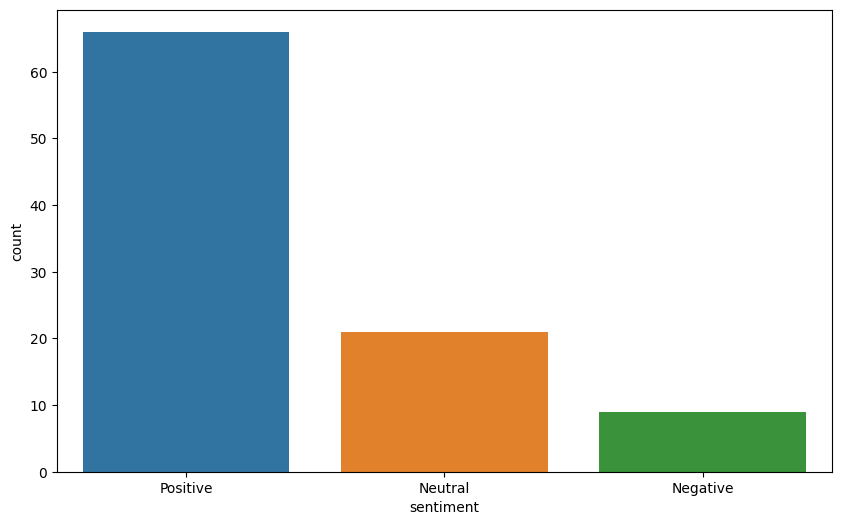

In [124]:
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment',data=df)

<Axes: xlabel='compound', ylabel='Count'>

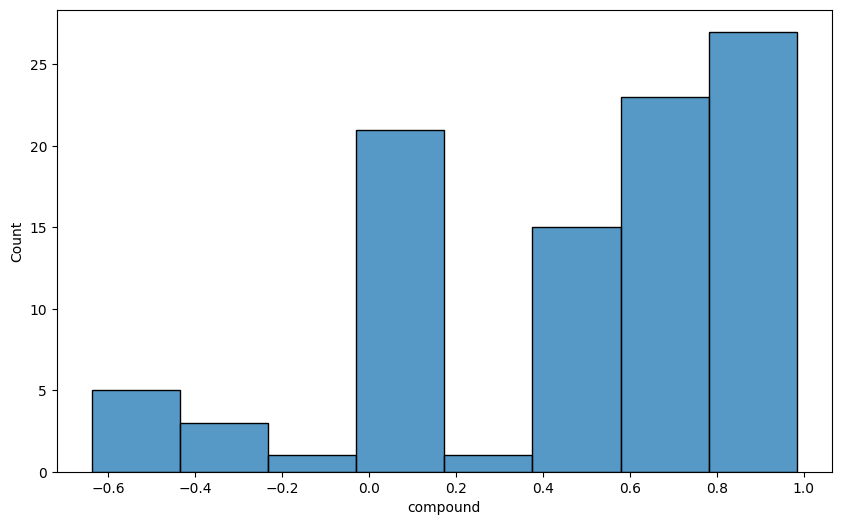

In [125]:
# Plotting the sentiment value for whole review
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(df['compound'])

In [126]:
# let's calculate subjectivity and Polarity
# function for subjectivity
def calc_subj(text):
    return TextBlob(text).sentiment.subjectivity

# function for Polarity
def calc_pola(text):
    return TextBlob(text).sentiment.polarity

dataframe['Subjectivity'] = dataframe.Clean_Reviews.apply(calc_subj)
dataframe['Polarity'] = dataframe.Clean_Reviews.apply(calc_pola)
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews,Subjectivity,Polarity
0,recently purchased realme narzo must say outst...,"I recently purchased the Realme Narzo 60, and ...",0.494629,0.269604
1,con camera could improved decent dropped pic b...,Cons1.The camera could be improved ( it's dece...,0.548413,0.364881
2,day reviewgood budget mobileprone display good...,2 days reviewGood budget mobileProne display i...,0.600000,0.700000
3,good displaygood battery hour backupgood camer...,"Good DisplayGood battery, more than 8 hours of...",0.492857,0.375714
4,display goodcamera good accepted better qualit...,Display -very goodCamera -good accepted more ...,0.466667,0.433333


Text(0, 0.5, 'Subjectivity')

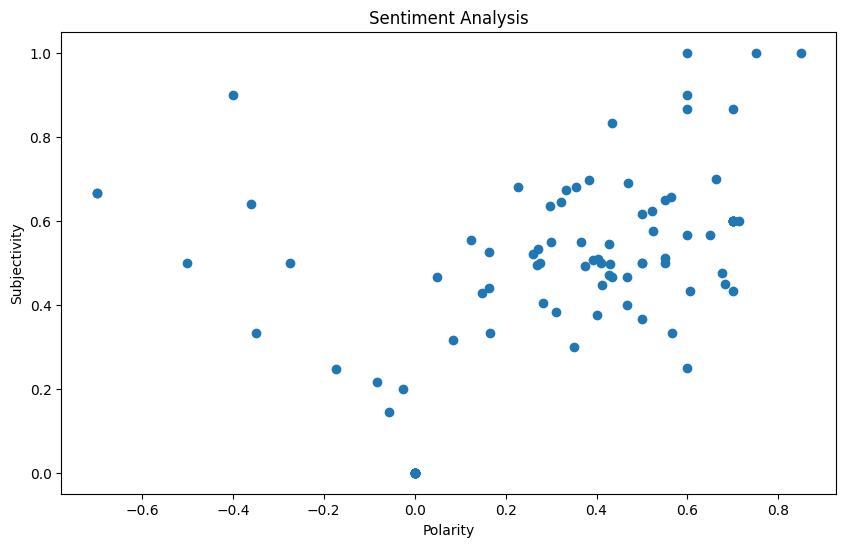

In [127]:
f, axes = plt.subplots(figsize = (10,6))
plt.scatter(dataframe.Polarity, dataframe.Subjectivity)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

In [128]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")


type_ = ["Positive", "Neutral", "Negative"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=df['sentiment'].value_counts(), name="sentiment"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Sentiment Analysis",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sentiment', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

**--> NLTK gives us more negative sentiments than TexBlob, so we will prefer NLTK, since classfication seems better.**

**Story Generation and Visualization**

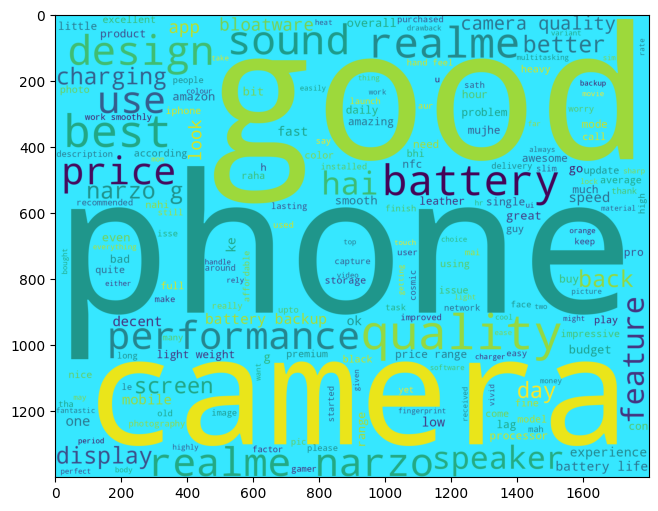

In [129]:
allWords_ = ' '.join([review for review in dataframe[:500]['Clean_Reviews']])
f, axes = plt.subplots(figsize=(10,6))
wordcloud= WordCloud(
        background_color = '#36e7ff',
        width = 1800,
        height =1400).generate(allWords_)
plt.imshow(wordcloud)